In [1]:
import sys
from pathlib import Path
from tqdm import tqdm

import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from skimage.measure import compare_ssim
from skimage.measure import compare_psnr

import chainer
import chainer.functions as F
sns.set(style='darkgrid')

sys.path.append('../experiments/SeqVG/')
from net import Encoder, Decoder, Discriminator
%matplotlib inline

In [2]:
FILE_PATH = Path('.').resolve()
ROOT_PATH = FILE_PATH.parent
RESULT_PATH = ROOT_PATH.joinpath('results/SeqVG')
MODEL_PATH = ROOT_PATH.joinpath('models/SeqVG')
print(FILE_PATH)
print(ROOT_PATH)
print(RESULT_PATH)
print(MODEL_PATH)

/home/shimo/CMULAB/Spatio-Temporal-SR/Notebooks
/home/shimo/CMULAB/Spatio-Temporal-SR
/home/shimo/CMULAB/Spatio-Temporal-SR/results/SeqVG
/home/shimo/CMULAB/Spatio-Temporal-SR/models/SeqVG


In [3]:
test_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_test.npy')) \
              .reshape(-1, 20, 1, 64, 64).astype(np.float32) / 255.0
train_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_train.npy')) \
               .reshape(-1, 20, 1, 64, 64).astype(np.float32) / 255.0
print(test_data.shape, test_data.dtype, train_data.max())
print(train_data.shape, train_data.dtype, train_data.max())

(1000, 20, 1, 64, 64) float32 1.0
(9000, 20, 1, 64, 64) float32 1.0


In [4]:
encoder = Encoder(64, 1, 100, 8)
decoder = Decoder(64, 1, 100, 8)

model_base_name = "{}_SeqVG_latent{}_ch{}_coef1{}_coef2{}_coef3{}_coef4{}.npz"

chainer.serializers.load_npz(MODEL_PATH.joinpath('mmnist',
    'Encoder_SeqVG_latent100_ch8_coef11.0_coef20.5_coef31.0_coef40.01.npz'), encoder)
chainer.serializers.load_npz(MODEL_PATH.joinpath('mmnist',
    'Decoder_SeqVG_latent100_ch8_coef11.0_coef20.5_coef31.0_coef40.01.npz'), decoder)

## 再構築

In [5]:
x = test_data[:9, 0]
print(x.shape)

with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_rec = F.sigmoid(decoder(encoder(x)[0])).array \
                .reshape(-1, 64, 64)
print(x_rec.shape, x_rec.max(), x_rec.min(), x_rec.dtype)
x_rec = np.clip(np.array(x_rec)*255, 0, 255).astype(np.uint8)

(9, 1, 64, 64)
(9, 64, 64) 0.99823976 0.0 float32


(9, 64, 64) 254 uint8


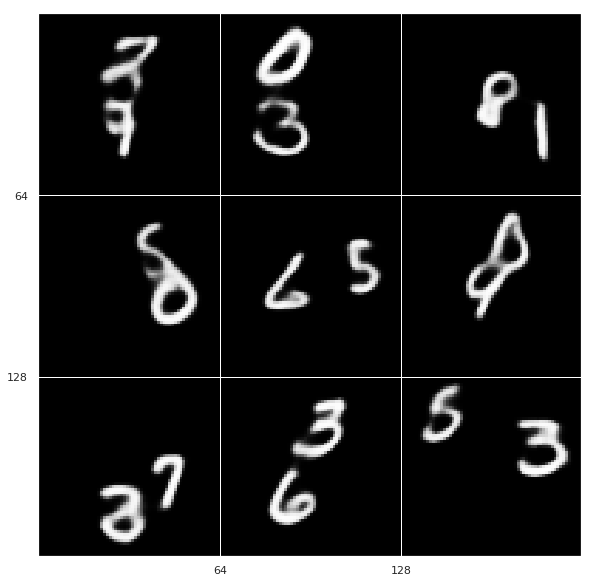

In [6]:
print(x_rec.shape, x_rec.max(), x_rec.dtype)

plt.figure(figsize=(10, 10))
plt.grid(True)
plt.xticks(np.arange(64, 64 * 3, 64))
plt.yticks(np.arange(64, 64 * 3, 64))
plt.imshow(x_rec.reshape(3,3,64,64).transpose(0,2,1,3).reshape(64*3, 64*3), cmap='gray')
plt.imsave('./images/SeqVG/mmnist_seqvaegan_noframe.png', x_rec.reshape(3,3,64,64).transpose(0,2,1,3).reshape(64*3, 64*3), cmap='gray')
plt.savefig('./images/SeqVG/mmnist_seqvaegan.png')
plt.show()

## psnr, ssim評価

In [7]:
# test
psnrs = []
ssims = []

for x_true in tqdm(test_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = F.sigmoid(decoder(encoder(x_true)[0])).array
    x_true = np.clip(x_true*255, 0, 255).astype(np.uint8).reshape(64,64)
    x_rec = np.clip(x_rec*255, 0, 255).astype(np.uint8).reshape(64,64)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

test_score = pd.DataFrame(np.array([psnrs, ssims]).T, columns=['test_psnr', 'test_ssim'])

100%|██████████| 1000/1000 [00:12<00:00, 82.87it/s]

psnr mean 19.659110114722335
ssim mean 0.8891884816843922


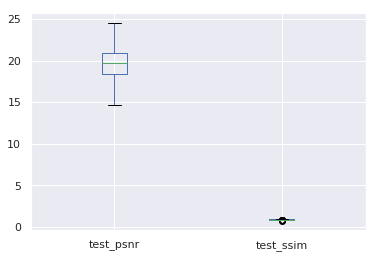

In [8]:
test_score.boxplot()

100%|██████████| 9000/9000 [01:52<00:00, 79.89it/s]


psnr mean 19.724015527094995
ssim mean 0.8900869609291666


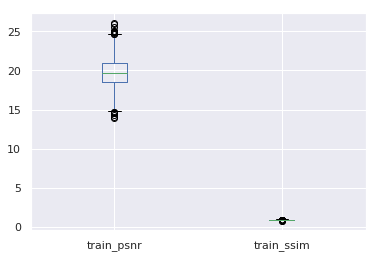

In [9]:
# train

psnrs = []
ssims = []

for x_true in tqdm(train_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = F.sigmoid(decoder(encoder(x_true)[0])).array
    x_true = np.clip(x_true*255, 0, 255).astype(np.uint8).reshape(64,64)
    x_rec = np.clip(x_rec*255, 0, 255).astype(np.uint8).reshape(64,64)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

train_score = pd.DataFrame(np.array([psnrs, ssims]).T, columns=['train_psnr', 'train_ssim'])
train_score.boxplot()

## 連続性評価

In [10]:
train_score.to_csv('images/SeqVG/SeqVG_train_score.csv')
test_score.to_csv('images/SeqVG/SeqVG_test_score.csv')

In [11]:
num_if = 10
seqs = []

midpoint = np.linspace(0, 1, num_if).astype(np.float32).reshape(num_if, 1, 1)

for i in tqdm(range(10)):
    xs = test_data[i, [0, 2, 4],:]
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        zs = encoder(xs)[0].array
        
        z_01 = zs[0] + np.kron(midpoint, (zs[1] - zs[0]))
        z_12 = zs[1] + np.kron(midpoint, (zs[2] - zs[1]))
        
        x_seq01 = F.sigmoid(decoder(z_01.reshape(-1, 100))).array
        x_seq12 = F.sigmoid(decoder(z_12.reshape(-1, 100))).array

    x_seq = np.concatenate((x_seq01, x_seq12[1:]), axis=0) \
                .reshape(-1, 64, 64).transpose(1, 0, 2).reshape(64, -1)

    seqs.append(x_seq)

seqs = np.array(seqs)
seq_images = np.clip(seqs * 255, 0, 255).astype(np.uint8)

100%|██████████| 10/10 [00:00<00:00, 10.01it/s]


In [12]:
gif_images = seq_images.reshape(10, 64, -1, 64).transpose(0, 2, 1, 3)

for idx, seq in enumerate(gif_images):
    ims = []
    for fr in seq:
        ims.append(Image.fromarray(fr).convert('RGB'))
    ims[0].save('images/SeqVG/mmnist_seqvg_{}.gif'.format(idx), save_all=True, append_images=ims[1:],
                optimize=False, duration=100, loop=0)

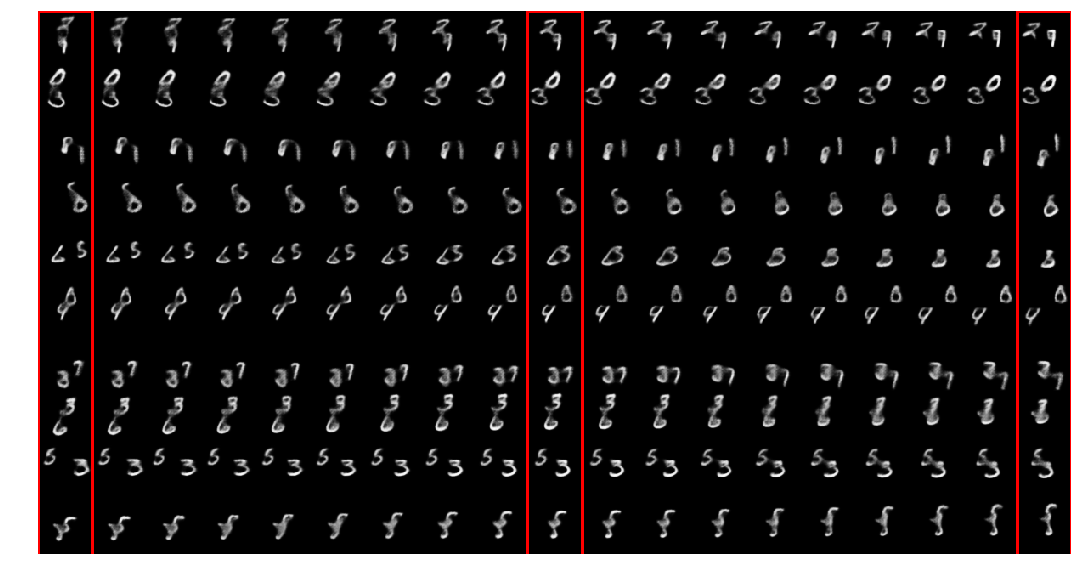

In [13]:
plt.figure(figsize=(19, 10))
plt.imshow(np.clip(seqs*255, 0, 255).reshape(640, 19*64), cmap='gray')
plt.imsave('./images/SeqVG/sequence_seqvaegan_mmnist_noframe.png', np.clip(seqs*255, 0, 255).reshape(640, 19*64), cmap='gray')
# plt.imshow(seqs_u, cmap='gray')

plt.axis('off')
rect = patches.Rectangle(xy=(0,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*9,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*18,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
plt.savefig('./images/SeqVG/sequence_seqvaegan_mmnist.png')
plt.show()